# Energy A.I. Hackathon 2021 Workflow - Team Anticline
## Simulation Based Imputation
#### Authors: Esmail Eltahan, Jeon Jonghyeon, Mehran Mehrabi, and Wen Pan, Hildebrand Department of Petroleum and Geosystems Engineering. 
#### The University of Texas at Austin, Austin, Texas USA 

<img src="anticline_official_logo.png" width=300 />



## Import packages

In [24]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import spatial
import seaborn as sns     #

## Load the data 

In [25]:
ai = np.load("2d_ai.npy")
sand_propotion = np.load("2d_sand_propotion.npy")
sandy_shale_propotion = np.load("2d_sandy_shale_propotion.npy")
shale_propotion = np.load("2d_shale_propotion.npy")
shaly_sand_propotion = np.load("2d_shaly_sand_propotion.npy")
top_depth = np.load("2d_top_depth.npy")
df_production = pd.read_csv('production_history.csv')

df_p = pd.read_csv('wellbore_data_producer_wells.csv')
df_n = pd.read_csv('wellbore_data_preproduction_well.csv')

## Add lithology identifier 

we add a column `lith_id` that takes values of $k={0,1,2,3}$, such that it serves as an identifier of rock facies. This is necessary such that we include the categorical variable in our analysis. Another way to include it is using the One Hot Encoder method, however we believe that the increase from 0 to 3 has meaningful value, as formation quality increases from shale to sandstone. In addition, we believe that this method of classification is sufficient for our purposes.

In [26]:
litho_keys = {'Shale':0,
                         'Sandy shale':1,
                         'Shaly sandstone': 2,
                         'Sandstone': 3}
def add_lith_id(df_p, df_n, litho_keys):
    dfs = [df_p, df_n]
    for df in dfs:
        df['layer']=np.arange(df.shape[0])%20
        df['lith_id'] = df['Rock facies'].map(litho_keys)
    return df_p, df_n
# add litho_id
df_p, df_n = add_lith_id(df_p, df_n, litho_keys)
static_well_dat=pd.concat([df_p,df_n])


## Iterative imputation

Here we use `IterativeImputer` from `sklearn` to fill in the missing values. Our strategy is to fill in all the propoerties using the `IterativeImputer` method expcept for porosity and permeability. Porosity and permeability will be imputed using the simulation realizations we already generated. 

We define two sets of variable `imp_vars_1` and `imp_vars_2` to make two separate imputations. We selected them based on our observation that within each group, there exists unique correlations.

The first set `imp_vars_1` includes:
- Porosity
- layer
- Acoustic Impedance 
- Permeability
- Density
- lith_id

The second set `imp_vars_2` includes:
- Density
- Compressible velocity
- Youngs modulus
- Shear velocity 
- Shear modulus

In [35]:
def iterative_impute_1(static_well_dat, imp_vars_1):
    
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer

    
    imp_dat_1 = static_well_dat[imp_vars_1].values.copy()
    imp_mean = IterativeImputer()
    imp_mean.fit(imp_dat_1)
    dat_transform_1=imp_mean.transform(imp_dat_1)
    dat_transform_1[:,-1][dat_transform_1[:,-1]<0]=0
    dat_transform_1[:,-1][dat_transform_1[:,-1]>3]=3
    dat_transform_1[:,-1]=np.rint(dat_transform_1[:,-1])
    dat_imputed_1 = pd.DataFrame(dat_transform_1)
    dat_imputed_1.columns= imp_vars_1
    dat_imputed_1.describe().T
    del IterativeImputer

    
    return dat_imputed_1
# iterative imputer
imp_vars_1 = ['Porosity, fraction','layer','Acoustic Impedance, kg/s-m^2','Permeability, mD', 'Density, g/cm3', 'lith_id']
dat_imputed_1 = iterative_impute_1(static_well_dat, imp_vars_1)


In [36]:
def iterative_impute_2(static_well_dat, imp_vars_2):
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer
    
    imp_dat_2 = static_well_dat[imp_vars_2].values.copy()
    imp_mean = IterativeImputer()
    imp_mean.fit(imp_dat_2)
    dat_transform_2=imp_mean.transform(imp_dat_2)

    dat_imputed_2 = pd.DataFrame(dat_transform_2)
    dat_imputed_2.columns= imp_vars_2
    dat_imputed_2.describe().T
    del IterativeImputer
    return dat_imputed_2

imp_vars_2 = ['Density, g/cm3', 'Compressible velocity, m/s', 'Youngs modulus, GPa',
       'Shear velocity, m/s', 'Shear modulus, GPa']
# dat_imputed_2 = iterative_impute_2(static_well_dat, imp_vars_2)
dat_imputed_2 = iterative_impute_2(static_well_dat, imp_vars_2)
# np.sum(dat_imputed_1 != dat_imputed_2)
# np.sum(dat_imputed_1 != static_well_dat[imp_vars_2].values)
# np.sum(np.isnan(static_well_dat[imp_vars_2].values))

/home/estahhan/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:669: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


As we discussed earlier, we fill in the values we obtained from imputations only for the following set of parameters `updated_vars`: 
- layer
- Acoustic Impedance 
- Density
- lith_id
- Compressible velocity
- Youngs modulus
- Shear velocity 
- Shear modulus

In [37]:
filled_vars_1 = ['lith_id', 'Acoustic Impedance, kg/s-m^2']
filled_vars_2 = ['Density, g/cm3', 'Compressible velocity, m/s', 'Youngs modulus, GPa',
       'Shear velocity, m/s', 'Shear modulus, GPa']

static_well_dat[filled_vars_1] = dat_imputed_1[filled_vars_1]
static_well_dat[filled_vars_2] = dat_imputed_2[filled_vars_2]
static_well_dat['lith_id'] = static_well_dat['lith_id'].astype('int')
inv_map = {v: k for k, v in litho_keys.items()}
static_well_dat['Rock facies'] = static_well_dat['lith_id'].map(inv_map)

In [38]:
end_index = df_p.shape[0]
updated_vars = filled_vars_1 + filled_vars_2 + ['Rock facies']
df_p.loc[:, updated_vars] = static_well_dat.iloc[:end_index][updated_vars]
df_n.loc[:, updated_vars] = static_well_dat.iloc[end_index:][updated_vars]

## Load simulated maps

Now we load the already simulated maps per facies that we obtained using sequential Gaussian simulations. The porosity and permeability maps are merged into two large array `sim_pors` and `sim_perms`. Each of the arrays has dimension $(4, L, N, N)$ where 4 is the number of facies, $L$ is the number of realizations, $N$ is the number of cells in $x$ and $y$ directions. 

In [39]:
sim_pors_0 = []
sim_pors_1 = []
sim_pors_2 = []
sim_pors_3 = []
sim_perms_0 = []
sim_perms_1 = []
sim_perms_2 = []
sim_perms_3 = []
N =100
for i in range(N):
    sim_perms_0.append(np.load("./sgs_maps/perm_shale_{0:03d}.npy".format(i)))
    sim_perms_1.append(np.load("./sgs_maps/perm_sandyshale_{0:03d}.npy".format(i)))
    sim_perms_2.append(np.load("./sgs_maps/perm_shalysand_{0:03d}.npy".format(i)))
    sim_perms_3.append(np.load("./sgs_maps/perm_sand_{0:03d}.npy".format(i)))
    
    sim_pors_0.append(np.load("./sgs_maps/por_shale_{0:03d}.npy".format(i)))
    sim_pors_1.append(np.load("./sgs_maps/por_sandyshale_{0:03d}.npy".format(i)))
    sim_pors_2.append(np.load("./sgs_maps/por_shalysand_{0:03d}.npy".format(i)))
    sim_pors_3.append(np.load("./sgs_maps/por_sand_{0:03d}.npy".format(i)))

In [40]:
sim_pors = np.array([sim_pors_0, sim_pors_1, sim_pors_2, sim_pors_3])
sim_perms = np.array([sim_perms_0, sim_perms_1, sim_perms_2, sim_perms_3])

## Fill from simulations and save to file

Now we iterate over the number of realizations $L$, fill in the porosity and permeability missing values at the well locations by interpolating the well location, facies at the depth of inquiry, with the corresponding values from the maps.

In [41]:
import warnings
warnings.filterwarnings('ignore')
L=1
for i in range(L): 
    # load data
    df_p = pd.read_csv('wellbore_data_producer_wells.csv')
    df_n = pd.read_csv('wellbore_data_preproduction_well.csv')
    # add litho_id
    df_p, df_n = add_lith_id(df_p, df_n, litho_keys)
    static_well_dat=pd.concat([df_p,df_n])
    # iterative imputer
    imp_vars_1 = ['Porosity, fraction','layer','Acoustic Impedance, kg/s-m^2','Permeability, mD', 'Density, g/cm3', 'lith_id']
    dat_imputed_1 = iterative_impute_1(static_well_dat, imp_vars_1)
    
    imp_vars_2 = ['Density, g/cm3', 'Compressible velocity, m/s', 'Youngs modulus, GPa',
           'Shear velocity, m/s', 'Shear modulus, GPa']
    dat_imputed_2 = iterative_impute_2(static_well_dat, imp_vars_2)
    
    filled_vars_1 = ['lith_id', 'Acoustic Impedance, kg/s-m^2']
    filled_vars_2 = ['Density, g/cm3', 'Compressible velocity, m/s', 'Youngs modulus, GPa',
           'Shear velocity, m/s', 'Shear modulus, GPa']
    
    static_well_dat[filled_vars_1] = dat_imputed_1[filled_vars_1]
    static_well_dat[filled_vars_2] = dat_imputed_2[filled_vars_2]
    static_well_dat['lith_id'] = static_well_dat['lith_id'].astype('int')
    inv_map = {v: k for k, v in litho_keys.items()}
    static_well_dat['Rock facies'] = static_well_dat['lith_id'].map(inv_map)
    updated_vars = filled_vars_1 + filled_vars_2 + ['Rock facies']
    df_p.loc[:, updated_vars] = static_well_dat.iloc[:end_index][updated_vars]
    df_n.loc[:, updated_vars] = static_well_dat.iloc[end_index:][updated_vars] 
    df_n_imputed = df_n.copy()
    mask = np.isnan(df_n_imputed['Porosity, fraction'])
    df_n_imputed.loc[mask, 'Porosity, fraction'] = sim_pors[df_n_imputed.loc[mask]['lith_id'], i,df_n_imputed.loc[mask]['X, m'].values//50, df_n_imputed.loc[mask]['Y, m'].values//50 ]
    mask = np.isnan(df_n_imputed['Permeability, mD'])
    df_n_imputed.loc[mask, 'Permeability, mD'] = sim_perms[df_n_imputed.loc[mask]['lith_id'], i,df_n_imputed.loc[mask]['X, m']//50, df_n_imputed.loc[mask]['Y, m']//50 ]
    df_n_imputed.to_csv("./imputed_data/df_n_{0:03d}.csv".format(i), index=False)
    
    df_p_imputed = df_p.copy()
    mask = np.isnan(df_p_imputed['Porosity, fraction'])
    df_p_imputed.loc[mask, 'Porosity, fraction'] = sim_pors[df_p_imputed.loc[mask]['lith_id'], i,df_p_imputed.loc[mask]['X, m'].values//50, df_p_imputed.loc[mask]['Y, m'].values//50 ]
    mask = np.isnan(df_p_imputed['Permeability, mD'])
    df_p_imputed.loc[mask, 'Permeability, mD'] = sim_perms[df_p_imputed.loc[mask]['lith_id'], i,df_p_imputed.loc[mask]['X, m']//50, df_p_imputed.loc[mask]['Y, m']//50 ]
    df_p_imputed.to_csv("./imputed_data/df_p_{0:03d}.csv".format(i), index=False)
    

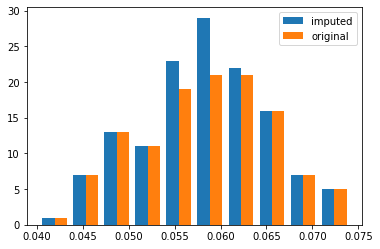

In [42]:
plt.hist([df_p_imputed.loc[df_p_imputed['lith_id']== 0]['Porosity, fraction'],df_p.loc[df_p['lith_id'] == 0]['Porosity, fraction']], label=['imputed', 'original'])
plt.legend()

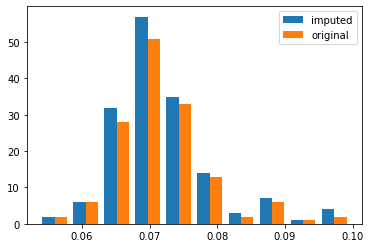

In [43]:
plt.hist([df_p_imputed.loc[df_p_imputed['lith_id']== 1]['Porosity, fraction'],df_p.loc[df_p['lith_id'] == 1]['Porosity, fraction']], label=['imputed', 'original'])
plt.legend()

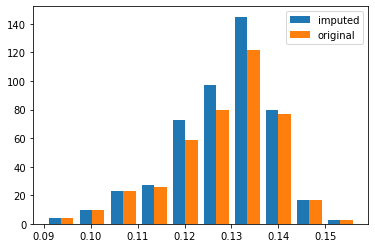

In [44]:
plt.hist([df_p_imputed.loc[df_p_imputed['lith_id']== 2]['Porosity, fraction'],df_p.loc[df_p['lith_id'] == 2]['Porosity, fraction']], label=['imputed', 'original'])
plt.legend()